# Feature augmentation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_125325/1062205650.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


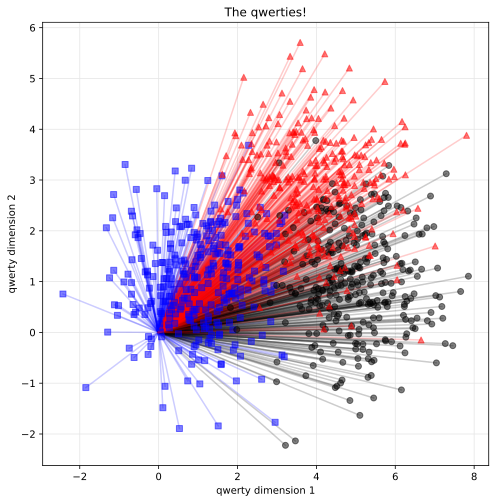

In [3]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(8,8))
# draw distance to origin
color = 'bkr'
for i in range(len(data)):
    plt.plot([0,data[i,0]],[0,data[i,1]],color=color[labels[i]],alpha=.2)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)

plt.grid(color=[.9,.9,.9])
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

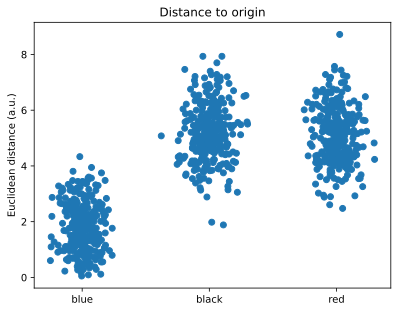

In [4]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt( data[:,0]**2 + data[:,1]**2 )

plt.plot(labels+torch.randn(900)/10,dist2orig,'o')
plt.xticks([0,1,2],labels=['blue','black','red'])
plt.ylabel('Euclidean distance (a.u.)')
plt.title('Distance to origin')
plt.show()

In [5]:
# Adding this to dataset

aug_data = torch.cat((data, dist2orig.view(len(data), 1)), axis=1)
print(data.shape)
print(aug_data.shape)
print(aug_data)

torch.Size([900, 2])
torch.Size([900, 3])
tensor([[-1.3253,  2.0599,  2.4494],
        [ 0.9536,  1.8181,  2.0530],
        [ 1.0667,  1.5304,  1.8655],
        ...,
        [ 4.7504,  2.4794,  5.3585],
        [ 3.4017,  2.5757,  4.2669],
        [ 5.4068,  2.0325,  5.7762]])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(aug_data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [7]:
# create a class for the model
def createTheQwertyNet(useExtraFeature=False):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            if useExtraFeature:
                self.input = nn.Linear(3,8)
            else:
                self.input = nn.Linear(2,8)

            ### hidden layer
            self.fc1 = nn.Linear(8,8)

            ### output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):

            # by request, only use XY features
#             print(x.shape) # comment out during training!
            if not useExtraFeature:
                x = x[:,:2]
#             print(x.shape) # comment out during training!

            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            return self.output(x)
  
    # create the model instance
    net = qwertyNet()

    # loss function
    lossfn = nn.CrossEntropyLoss()

    # optimizer
    optim = torch.optim.SGD(net.parameters(),lr=.001)

    return net, lossfn, optim

In [8]:
# test the model

print('Using augmented feature:')
net = createTheQwertyNet(True)[0]
net(next(iter(trainLoader))[0]);

print('\nNot using augmented feature:')
net = createTheQwertyNet(False)[0]
net(next(iter(trainLoader))[0]);

Using augmented feature:

Not using augmented feature:


In [9]:
# a function that trains the model

def function2trainTheModel(useExtraFeature=False):

  # number of epochs
  numepochs = 200
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(useExtraFeature)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in trainLoader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(testLoader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [10]:
#
def plotTheResults():

  # compute accuracy over entire dataset (train+test)
  yHat = net(aug_data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title('Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title('Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title('Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(aug_data[labels==i,0],aug_data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    
    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(aug_data[idxErr,0],aug_data[idxErr,1],'rx')

  ax[1,1].set_title('All groups')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  
  plt.tight_layout()
  plt.show()

Final accuracy: 86.67%


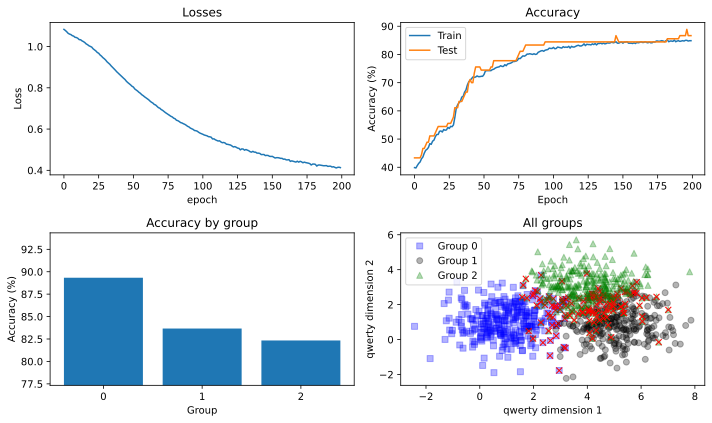

In [11]:
# run the model and visualize the results WITHOUT EXTRA FEATURE
trainAcc,testAcc,losses,net = function2trainTheModel(False)
print('Final accuracy: %.2f%%' %testAcc[-1].item())
plotTheResults()

Final accuracy: 85.56%


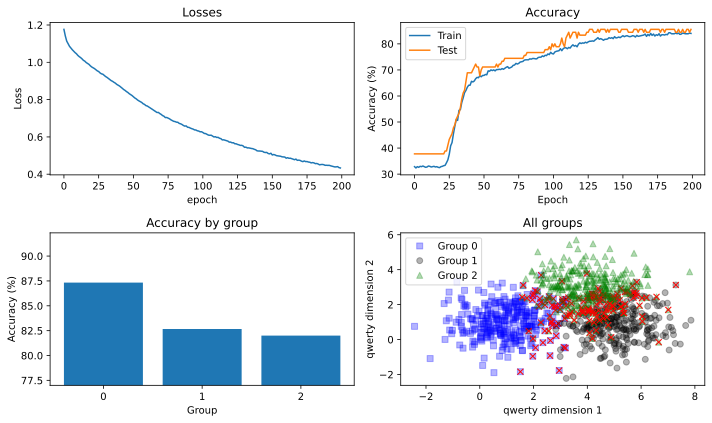

In [12]:
# run the model and visualize the results WITH EXTRA FEATURE
trainAcc,testAcc,losses,net = function2trainTheModel(True)
print('Final accuracy: %.2f%%' %testAcc[-1].item())
plotTheResults()

In [13]:
# Run the experiment multiple times and do a t-test!
# (takes ~3 mins)

finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
  finalacc2[i] = function2trainTheModel(False)[1][-1]
  finalacc3[i] = function2trainTheModel(True)[1][-1]

# show the numbers
print( np.round(np.vstack((finalacc2,finalacc3)).T,2) )

# run the t-test and print the results
from scipy import stats
t,p = stats.ttest_ind(finalacc3,finalacc2)
print('\n\nt=%.2f, p=%.2f' %(t,p))

[[87.78 85.56]
 [84.44 83.33]
 [84.44 85.56]
 [84.44 83.33]
 [66.67 84.44]
 [86.67 86.67]
 [87.78 84.44]
 [86.67 71.11]
 [85.56 80.  ]
 [81.11 85.56]]


t=-0.23, p=0.82


# Save and load models

Create and run a DL model first

/tmp/ipykernel_125325/2537921934.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


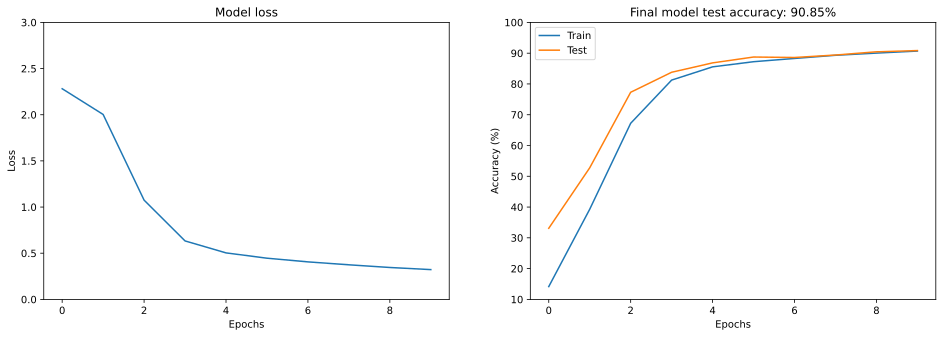

In [15]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

trainAcc,testAcc,losses,net = funtion2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Saving the model

we save using ```<model_name>.state_dict``` that holds all the weights, biases, and other properties of the model

In [16]:
torch.save(net.state_dict(), '../models/sample_trained_model.pt')

### Load model using different name

In [17]:
# create two new models of same class
m1, m2 = createTheMNISTNet()[0], createTheMNISTNet()[0]

# replacing model parameters with trained model's
m1.load_state_dict(torch.load('../models/sample_trained_model.pt'))

<All keys matched successfully>

### Showing that models are same

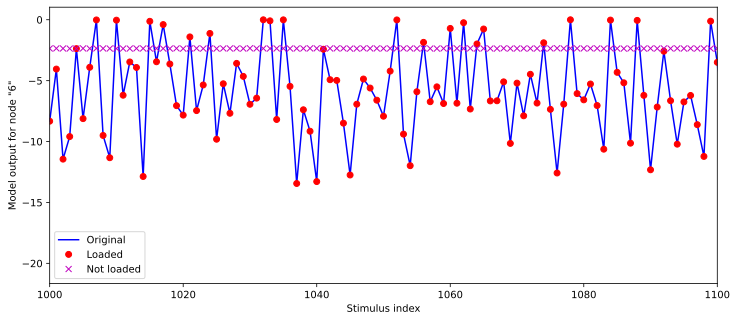

In [19]:
# get some data from the test loader
X,y = next(iter(test_loader))

# run the data through both models
yHatNet    = net(X)
yHatModel1 = m1(X)
yHatModel2 = m2(X)


# show that the results overlap
fig = plt.figure(figsize=(12,5))
plt.plot(yHatNet[:,5].detach(),'b',label='Original')
plt.plot(yHatModel1[:,5].detach(),'ro',label='Loaded')
plt.plot(yHatModel2[:,5].detach(),'mx',label='Not loaded')
plt.legend()
plt.xlabel('Stimulus index')
plt.ylabel('Model output for node "6"')
plt.xlim([1000,1100])

plt.show()

# Saving the best model

In [20]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_125325/3865040932.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [21]:
theBest = [0,0]

for i in range(10):

  # "train the model"
  accuracy = np.random.rand()

  # see if this is better than any previous runs
  if accuracy>theBest[0]:
    theBest = [accuracy,i]


print(f'Highest "accuracy" was {100*theBest[0]:.2f}% in run {theBest[1]+1}.')

Highest "accuracy" was 99.44% in run 4.


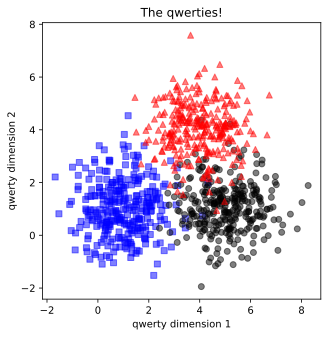

   Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
  Devset data size: torch.Size([200, 2])
    Test data size: torch.Size([200, 2])


In [22]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# specify sizes of the partitions
# order is train,devset,test
partitions = [3*nPerClust-400,200,200]

# split the data
train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0])

# now split the devtest data
dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])


# print out the sizes
print('   Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('  Devset data size: ' + str(dev_data.shape))
print('    Test data size: ' + str(test_data.shape))

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 30
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create and validate the model

# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer


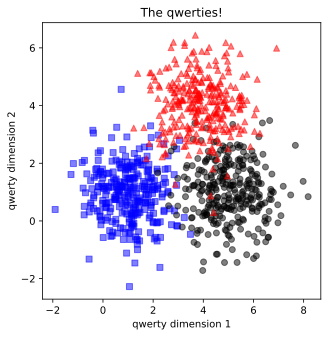

   Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
  Devset data size: torch.Size([200, 2])
    Test data size: torch.Size([200, 2])


In [23]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# specify sizes of the partitions
# order is train,devset,test
partitions = [3*nPerClust-400,200,200]

# split the data
train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0])

# now split the devtest data
dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])


# print out the sizes
print('   Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('  Devset data size: ' + str(dev_data.shape))
print('    Test data size: ' + str(test_data.shape))

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 30
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create and validate the model

# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer
def funtion2trainTheModel():

  # New! initialize a dictionary for the best model
  theBestModel = {'Accuracy':0, 'net':None}


  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  devAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


    # New! Store this model if it's the best so far
    if devAcc[-1]>theBestModel['Accuracy']:
      
      # new best accuracy
      theBestModel['Accuracy'] = devAcc[-1].item()
      
      # model's internal state
      theBestModel['net'] = copy.deepcopy( net.state_dict() )
      
  # end epochs

  # function output
  return trainAcc,devAcc,losses,theBestModel


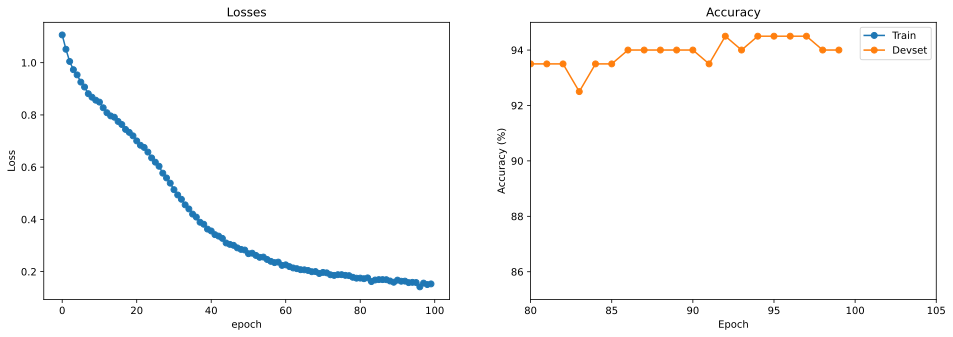

In [24]:
# run the model
trainAcc,devAcc,losses,theBestModel = funtion2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses.detach(),'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,'o-',label='Train')
ax[1].plot(devAcc,'o-',label='Devset')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].set_ylim([85,95])
ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

In [25]:
theBestModel

{'Accuracy': 94.5,
 'net': OrderedDict([('input.weight',
               tensor([[ 0.0460, -0.0787],
                       [ 1.1286, -0.9332],
                       [-0.6578,  0.5144],
                       [-0.4577,  0.5243],
                       [-0.0706, -0.6213],
                       [ 0.2638,  0.0558],
                       [-0.1450,  0.1108],
                       [ 0.6313,  0.8137]])),
              ('input.bias',
               tensor([ 0.2150,  0.2071, -0.4119,  0.7098,  0.4842, -0.2852, -0.5851, -0.9596])),
              ('fc1.weight',
               tensor([[ 3.0244e-01,  4.1798e-01, -1.0592e-01, -1.1901e-01,  4.1725e-02,
                        -2.7785e-02, -5.4895e-02, -1.1673e-01],
                       [ 3.1168e-02, -2.9280e-01,  2.6873e-01,  1.5763e-01, -3.1841e-01,
                        -5.7299e-02,  3.5163e-01, -1.3569e-01],
                       [ 7.3095e-02,  4.7890e-01, -2.1721e-01,  6.8900e-01, -1.3958e-01,
                        -2.7590e-01, -3.3019e

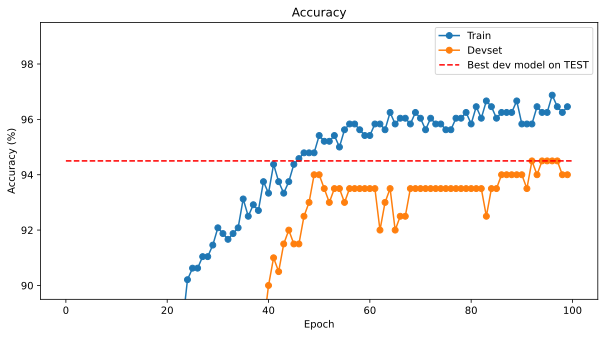

In [26]:
# extract X,y from test dataloader
X,y = next(iter(test_loader)) 

# yHat = theBestModel['net'](X)

# recreate the best-performing model
bestnet = createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel['net'])


# and run the data through TEST
X,y = next(iter(test_loader)) 
yHat = bestnet(X)

bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
bestAcc

fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'o-',label='Train')
plt.plot(devAcc,'o-',label='Devset')
plt.plot([0,len(devAcc)],[bestAcc,bestAcc],'r--',label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.ylim([bestAcc-5,bestAcc+5])
plt.legend()
plt.show()